## W&B Key - "4d4d4c8f520ba4f560db3da3a2e051523a812c46"

In [1]:
!nvidia-smi

Sat Jan 10 07:00:39 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-80GB          Off |   00000000:00:05.0 Off |                    0 |
| N/A   35C    P0             54W /  400W |       0MiB /  81920MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [2]:
!git clone https://github.com/PerforatedAI/PerforatedAI.git
%cd PerforatedAI

# install
!pip install -e .

# Install dependencies
!pip install -q transformers datasets accelerate wandb

Cloning into 'PerforatedAI'...
remote: Enumerating objects: 1383, done.
remote: Counting objects: 100% (339/339), done.
remote: Compressing objects: 100% (108/108), done.
remote: Total 1383 (delta 249), reused 231 (delta 231), pack-reused 1044 (from 2)
Receiving objects: 100% (1383/1383), 72.27 MiB | 14.94 MiB/s, done.
Resolving deltas: 100% (764/764), done.
/content/PerforatedAI
Obtaining file:///content/PerforatedAI
  Preparing metadata (setup.py) ... done
  Running setup.py develop for perforatedai


## CIFAR-10 dataset start with new basline and dentrics

In [3]:
!pip install -q torch torchvision tqdm wandb

import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from tqdm.auto import tqdm
import wandb

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
# CIFAR-10 normalization (standard)
mean = (0.4914, 0.4822, 0.4465)             # per channel mean, normalisation constants
std  = (0.2470, 0.2435, 0.2616)

train_tfms = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

test_tfms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

train_ds = datasets.CIFAR10(root="./data", train=True, download=True, transform=train_tfms)
test_ds  = datasets.CIFAR10(root="./data", train=False, download=True, transform=test_tfms)

BATCH_SIZE = 128
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

NUM_CLASSES = 10

100%|██████████| 170M/170M [06:51<00:00, 414kB/s]


In [5]:
def build_resnet18_cifar10(num_classes=10):         # ResNet18 set-up
    m = models.resnet18(weights=None)
    m.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    m.maxpool = nn.Identity()
    m.fc = nn.Linear(m.fc.in_features, num_classes)
    return m

baseline_model = build_resnet18_cifar10(NUM_CLASSES).to(device)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Baseline params:", count_parameters(baseline_model))

Baseline params: 11173962


In [6]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

@torch.no_grad()
def evaluate_accuracy(model, loader):
    model.eval()
    correct, total = 0, 0
    for x, y in loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)
        logits = model(x)
        preds = logits.argmax(dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)
    return correct / total

def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    for x, y in loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * y.size(0)

    return running_loss / len(loader.dataset)

@torch.no_grad()
def benchmark_latency(model, loader, n_batches=30, warmup=10):
    model.eval()
    it = iter(loader)

    # warmup
    for _ in range(warmup):
        x, _ = next(it)
        x = x.to(device, non_blocking=True)
        _ = model(x)
    if device.type == "cuda":
        torch.cuda.synchronize()

    start = time.time()
    for _ in range(n_batches):
        x, _ = next(it)
        x = x.to(device, non_blocking=True)
        _ = model(x)
    if device.type == "cuda":
        torch.cuda.synchronize()
    end = time.time()

    return (end - start) / n_batches

In [7]:
def build_resnet18_cifar10(num_classes=10):
    m = models.resnet18(weights=None)
    m.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    m.maxpool = nn.Identity()
    m.fc = nn.Linear(m.fc.in_features, num_classes)
    return m

def build_shufflenetv2_cifar10(num_classes=10):
    m = models.shufflenet_v2_x1_0(weights=None)
    # replace classifier
    m.fc = nn.Linear(m.fc.in_features, num_classes)
    return m

In [8]:
import copy


WANDB_PROJECT = "perforatedai-hackathon-cifar10"

hist_A = {"epoch": [], "train_acc": [], "test_acc": []}

model_A = build_resnet18_cifar10(NUM_CLASSES).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_A.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

run = wandb.init(project=WANDB_PROJECT, name="A_resnet18_no_dendrites", reinit=True)

EPOCHS_A = 20
best_acc = 0.0
best_state = None

for epoch in range(EPOCHS_A):
    train_loss = train_one_epoch(model_A, train_loader, optimizer, criterion)
    train_acc = evaluate_accuracy(model_A, train_loader)
    test_acc  = evaluate_accuracy(model_A, test_loader)
    scheduler.step()

    hist_A["epoch"].append(epoch)
    hist_A["train_acc"].append(train_acc)
    hist_A["test_acc"].append(test_acc)

    wandb.log({
        "epoch": epoch,
        "train/loss": train_loss,
        "train/accuracy": train_acc,
        "test/accuracy": test_acc,
        "lr": optimizer.param_groups[0]["lr"],
    })

    print(f"[A] epoch={epoch:02d} train_acc={train_acc:.4f} test_acc={test_acc:.4f}")

    if test_acc > best_acc:
        best_acc = test_acc
        best_state = copy.deepcopy(model_A.state_dict())

model_A.load_state_dict(best_state)
final_A_acc = evaluate_accuracy(model_A, test_loader)
final_A_params = count_parameters(model_A)
final_A_latency = benchmark_latency(model_A, test_loader)

wandb.log({"final/accuracy": final_A_acc, "final/params": final_A_params, "final/latency_sec_per_batch": final_A_latency})
run.finish()

print("\n=== A FINAL ===")
print("Accuracy:", final_A_acc)
print("Params:", final_A_params)
print("Latency (sec/batch):", final_A_latency)

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 2


wandb: You chose 'Use an existing W&B account'
wandb: Logging into https://api.wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: Find your API key here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: warkevishal29 (warkevishal292) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


[A] epoch=00 train_acc=0.4370 test_acc=0.4408
[A] epoch=01 train_acc=0.5368 test_acc=0.5315
[A] epoch=02 train_acc=0.6519 test_acc=0.6384
[A] epoch=03 train_acc=0.7014 test_acc=0.6865
[A] epoch=04 train_acc=0.7209 test_acc=0.7178
[A] epoch=05 train_acc=0.7598 test_acc=0.7498
[A] epoch=06 train_acc=0.8162 test_acc=0.8009
[A] epoch=07 train_acc=0.7985 test_acc=0.7854
[A] epoch=08 train_acc=0.8350 test_acc=0.8164
[A] epoch=09 train_acc=0.8598 test_acc=0.8398
[A] epoch=10 train_acc=0.8662 test_acc=0.8436
[A] epoch=11 train_acc=0.8692 test_acc=0.8399
[A] epoch=12 train_acc=0.8914 test_acc=0.8621
[A] epoch=13 train_acc=0.9113 test_acc=0.8792
[A] epoch=14 train_acc=0.9336 test_acc=0.8926
[A] epoch=15 train_acc=0.9497 test_acc=0.9066
[A] epoch=16 train_acc=0.9652 test_acc=0.9145
[A] epoch=17 train_acc=0.9760 test_acc=0.9192
[A] epoch=18 train_acc=0.9824 test_acc=0.9236
[A] epoch=19 train_acc=0.9832 test_acc=0.9239


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
final/accuracy,▁
final/latency_sec_per_batch,▁
final/params,▁
lr,███▇▇▇▆▆▅▅▄▃▃▂▂▂▁▁▁▁
test/accuracy,▁▂▄▅▅▅▆▆▆▇▇▇▇▇██████
train/accuracy,▁▂▄▄▅▅▆▆▆▆▇▇▇▇▇█████
train/loss,█▆▅▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁
epoch,19
final/accuracy,0.9239
final/latency_sec_per_batch,0.01795



=== A FINAL ===
Accuracy: 0.9239
Params: 11173962
Latency (sec/batch): 0.017953141530354818


In [9]:
hist_B = {"epoch": [], "train_acc": [], "test_acc": []}

model_B = build_shufflenetv2_cifar10(NUM_CLASSES).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_B.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

run = wandb.init(project=WANDB_PROJECT, name="B_shufflenet_no_dendrites", reinit=True)

EPOCHS_B = 20
best_acc = 0.0
best_state = None

for epoch in range(EPOCHS_B):
    train_loss = train_one_epoch(model_B, train_loader, optimizer, criterion)
    train_acc = evaluate_accuracy(model_B, train_loader)
    test_acc  = evaluate_accuracy(model_B, test_loader)
    scheduler.step()

    hist_B["epoch"].append(epoch)
    hist_B["train_acc"].append(train_acc)
    hist_B["test_acc"].append(test_acc)

    wandb.log({
        "epoch": epoch,
        "train/loss": train_loss,
        "train/accuracy": train_acc,
        "test/accuracy": test_acc,
        "lr": optimizer.param_groups[0]["lr"],
    })

    print(f"[B] epoch={epoch:02d} train_acc={train_acc:.4f} test_acc={test_acc:.4f}")

    if test_acc > best_acc:
        best_acc = test_acc
        best_state = copy.deepcopy(model_B.state_dict())

model_B.load_state_dict(best_state)
final_B_acc = evaluate_accuracy(model_B, test_loader)
final_B_params = count_parameters(model_B)
final_B_latency = benchmark_latency(model_B, test_loader)

wandb.log({"final/accuracy": final_B_acc, "final/params": final_B_params, "final/latency_sec_per_batch": final_B_latency})
run.finish()

print("\n=== B FINAL ===")
print("Accuracy:", final_B_acc)
print("Params:", final_B_params)
print("Latency (sec/batch):", final_B_latency)

[B] epoch=00 train_acc=0.3522 test_acc=0.3655
[B] epoch=01 train_acc=0.4484 test_acc=0.4792
[B] epoch=02 train_acc=0.4738 test_acc=0.4977
[B] epoch=03 train_acc=0.4970 test_acc=0.5261
[B] epoch=04 train_acc=0.5177 test_acc=0.5271
[B] epoch=05 train_acc=0.5288 test_acc=0.5454
[B] epoch=06 train_acc=0.5479 test_acc=0.5664
[B] epoch=07 train_acc=0.5800 test_acc=0.5961
[B] epoch=08 train_acc=0.5887 test_acc=0.6075
[B] epoch=09 train_acc=0.5892 test_acc=0.6094
[B] epoch=10 train_acc=0.6297 test_acc=0.6355
[B] epoch=11 train_acc=0.6436 test_acc=0.6641
[B] epoch=12 train_acc=0.6647 test_acc=0.6669
[B] epoch=13 train_acc=0.6797 test_acc=0.6842
[B] epoch=14 train_acc=0.7059 test_acc=0.7167
[B] epoch=15 train_acc=0.7191 test_acc=0.7171
[B] epoch=16 train_acc=0.7412 test_acc=0.7359
[B] epoch=17 train_acc=0.7515 test_acc=0.7447
[B] epoch=18 train_acc=0.7619 test_acc=0.7478
[B] epoch=19 train_acc=0.7652 test_acc=0.7518


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
final/accuracy,▁
final/latency_sec_per_batch,▁
final/params,▁
lr,███▇▇▇▆▆▅▅▄▃▃▂▂▂▁▁▁▁
test/accuracy,▁▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇████
train/accuracy,▁▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇████
train/loss,█▆▅▅▄▄▄▄▃▃▃▃▂▂▂▂▁▁▁▁
epoch,19
final/accuracy,0.7518
final/latency_sec_per_batch,0.01584



=== B FINAL ===
Accuracy: 0.7518
Params: 1263854
Latency (sec/batch): 0.01584326426188151


In [25]:
from perforatedai import globals_perforatedai as GPA
from perforatedai import utils_perforatedai as UPA
import os

os.environ["PYTHONBREAKPOINT"] = "0"

GPA.pc.set_unwrapped_modules_confirmed(True)
GPA.pc.set_testing_dendrite_capacity(False)

In [26]:
model_C = build_shufflenetv2_cifar10(NUM_CLASSES)

model_C = UPA.initialize_pai(model_C)
model_C = model_C.to(device)

print("C params (initial):", count_parameters(model_C))

criterion = nn.CrossEntropyLoss()

Running Dendrite Experiment
C params (initial): 2511528


In [28]:
INITIAL_LR = 3e-4
WEIGHT_DECAY = 0.01

GPA.pai_tracker.set_optimizer(torch.optim.AdamW)
GPA.pai_tracker.set_scheduler(torch.optim.lr_scheduler.ReduceLROnPlateau)

optim_args = {
    "params": model_C.parameters(),
    "lr": INITIAL_LR,
    "weight_decay": WEIGHT_DECAY,
}

# NOTE: do NOT include "verbose" (your torch version doesn't support it)
sched_args = {
    "mode": "max",     # maximize accuracy
    "patience": 3,
    "factor": 0.5,
}

optimizer_C, scheduler_C = GPA.pai_tracker.setup_optimizer(
    model_C,
    optim_args,
    sched_args,
)

In [29]:
hist_C = {"epoch": [], "train_acc": [], "test_acc": [], "restructured_epoch": [], "params": []}

def train_with_dendrites_cifar(
    model,
    optimizer,
    optim_args,
    sched_args,
    max_epochs=80,
    run_name="C_shufflenet_dendrites",
):
    run = wandb.init(project=WANDB_PROJECT, name=run_name, reinit="finish_previous")

    for epoch in range(max_epochs):
        model.train()

        # train epoch
        for x, y in train_loader:
            x = x.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)

            optimizer.zero_grad(set_to_none=True)
            logits = model(x)
            loss = criterion(logits, y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

        # metrics
        train_acc = evaluate_accuracy(model, train_loader)
        test_acc  = evaluate_accuracy(model, test_loader)

        # PAI decision for restructuring
        model, restructured, training_complete = GPA.pai_tracker.add_validation_score(test_acc, model)

        model = model.to(device)

        if restructured:
            hist_C["restructured_epoch"].append(epoch)
            optimizer, scheduler = GPA.pai_tracker.setup_optimizer(model, optim_args, sched_args)
        else:
            scheduler = None  # not used directly (PAI steps internally)

        # ---- log ----
        hist_C["epoch"].append(epoch)
        hist_C["train_acc"].append(train_acc)
        hist_C["test_acc"].append(test_acc)
        hist_C["params"].append(count_parameters(model))

        wandb.log({
            "epoch": epoch,
            "train/accuracy": train_acc,
            "test/accuracy": test_acc,
            "pai/restructured": int(restructured),
            "pai/training_complete": int(training_complete),
            "pai/params": count_parameters(model),
        })

        print(f"[C] epoch={epoch:02d} train_acc={train_acc:.4f} test_acc={test_acc:.4f} restructured={restructured} params={count_parameters(model)}")

        if training_complete:
            print("PerforatedAI reports training complete.")
            break

    run.finish()
    return model

model_C = train_with_dendrites_cifar(
    model_C,
    optimizer_C,
    optim_args,
    sched_args,
    max_epochs=80,
)

final_C_acc = evaluate_accuracy(model_C, test_loader)
final_C_params = count_parameters(model_C)
final_C_latency = benchmark_latency(model_C, test_loader)

print("\n=== C FINAL ===")
print("Accuracy:", final_C_acc)
print("Params:", final_C_params)
print("Latency (sec/batch):", final_C_latency)
print("Dendrite restructure epochs:", hist_C["restructured_epoch"])

Adding validation score 0.30680000
Checking PAI switch with mode n, switch mode DOING_HISTORY, epoch 0, last improved epoch 0, total epochs 0, n: 10, num_cycles: 0
Returning False - no triggers to switch have been hit
[C] epoch=00 train_acc=0.2765 test_acc=0.3068 restructured=0 params=2511528
Adding validation score 0.39860000
Checking PAI switch with mode n, switch mode DOING_HISTORY, epoch 1, last improved epoch 1, total epochs 1, n: 10, num_cycles: 0
Returning False - no triggers to switch have been hit
[C] epoch=01 train_acc=0.3732 test_acc=0.3986 restructured=0 params=2511528
Adding validation score 0.47380000
Checking PAI switch with mode n, switch mode DOING_HISTORY, epoch 2, last improved epoch 2, total epochs 2, n: 10, num_cycles: 0
Returning False - no triggers to switch have been hit
[C] epoch=02 train_acc=0.4422 test_acc=0.4738 restructured=0 params=2511528
Adding validation score 0.50900000
Checking PAI switch with mode n, switch mode DOING_HISTORY, epoch 3, last improved 

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
pai/params,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█
pai/restructured,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁
pai/training_complete,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test/accuracy,▁▂▂▃▃▄▄▄▄▄▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇███████████
train/accuracy,▁▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇████████
epoch,79
pai/params,3767302
pai/restructured,0
pai/training_complete,0
test/accuracy,0.751



=== C FINAL ===
Accuracy: 0.751
Params: 3767302
Latency (sec/batch): 0.036136809984842935
Dendrite restructure epochs: [76]


In [34]:
print("len(hist_C['epoch']):", len(hist_C["epoch"]))
print("len(hist_B['epoch']):", len(hist_B["epoch"]))
print("example hist_C:", hist_C["epoch"][:5], hist_C["test_acc"][:5])
print("example hist_B:", hist_B["epoch"][:5], hist_B["test_acc"][:5])


len(hist_C['epoch']): 80
len(hist_B['epoch']): 20
example hist_C: [0, 1, 2, 3, 4] [0.3068, 0.3986, 0.4738, 0.509, 0.5304]
example hist_B: [0, 1, 2, 3, 4] [0.3655, 0.4792, 0.4977, 0.5261, 0.5271]


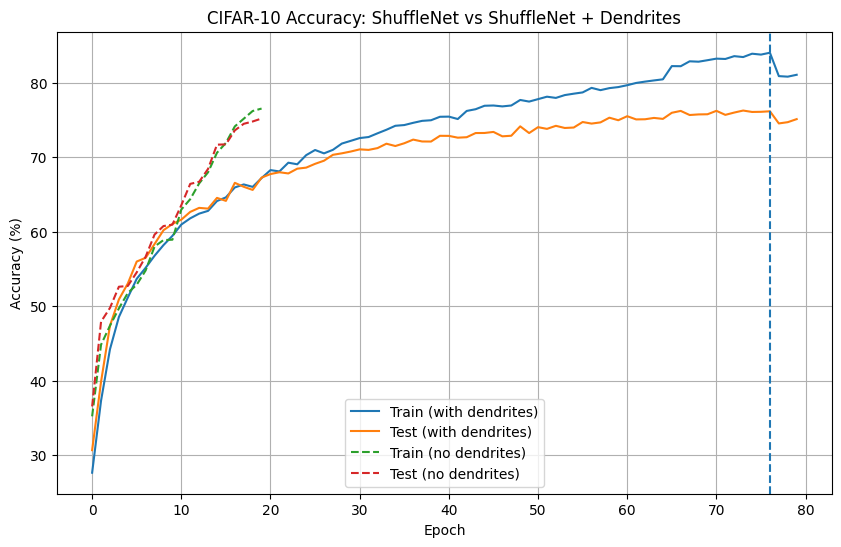

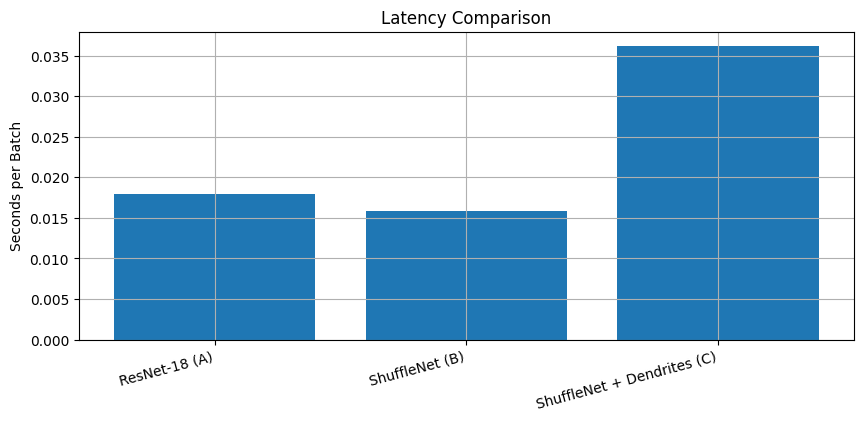

In [38]:
import matplotlib
import matplotlib.pyplot as plt

# Accuracy curves
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(hist_C["epoch"], [a * 100 for a in hist_C["train_acc"]], label="Train (with dendrites)")
ax.plot(hist_C["epoch"], [a * 100 for a in hist_C["test_acc"]],  label="Test (with dendrites)")

ax.plot(hist_B["epoch"], [a * 100 for a in hist_B["train_acc"]], label="Train (no dendrites)", linestyle="--")
ax.plot(hist_B["epoch"], [a * 100 for a in hist_B["test_acc"]],  label="Test (no dendrites)", linestyle="--")

for e in hist_C.get("restructured_epoch", []):
    ax.axvline(x=e, linestyle="--")

ax.set_xlabel("Epoch")
ax.set_ylabel("Accuracy (%)")
ax.set_title("CIFAR-10 Accuracy: ShuffleNet vs ShuffleNet + Dendrites")
ax.legend()
ax.grid(True)

plt.show()


# Latency comparison
fig, ax = plt.subplots(figsize=(10, 4))

labels = ["ResNet-18 (A)", "ShuffleNet (B)", "ShuffleNet + Dendrites (C)"]
lats = [final_A_latency, final_B_latency, final_C_latency]

ax.bar(labels, lats)
ax.set_ylabel("Seconds per Batch")
ax.set_title("Latency Comparison")
plt.xticks(rotation=15, ha="right")
ax.grid(True)

plt.show()

In [36]:
# ---------- Summary print ----------
print("\n=== FINAL SUMMARY ===")
print("A ResNet-18:", final_A_acc, final_A_params, final_A_latency)
print("B ShuffleNet:", final_B_acc, final_B_params, final_B_latency)
print("C ShuffleNet+dendrites:", final_C_acc, final_C_params, final_C_latency)
print("Dendrite events (epochs):", hist_C.get("restructured_epoch", []))


=== FINAL SUMMARY ===
A ResNet-18: 0.9239 11173962 0.017953141530354818
B ShuffleNet: 0.7518 1263854 0.01584326426188151
C ShuffleNet+dendrites: 0.751 3767302 0.036136809984842935
Dendrite events (epochs): [76]
